<a href="https://colab.research.google.com/github/ARnord-Trigger/CNN-from-scratch-using-Numpy/blob/master/Copy_of_Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [29]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-2d5sqoyd
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-2d5sqoyd
  Resolved https://github.com/albumentations-team/albumentations to commit bcaf7d679c6dec01f2cd0170bef16b3076e7eae6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [30]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


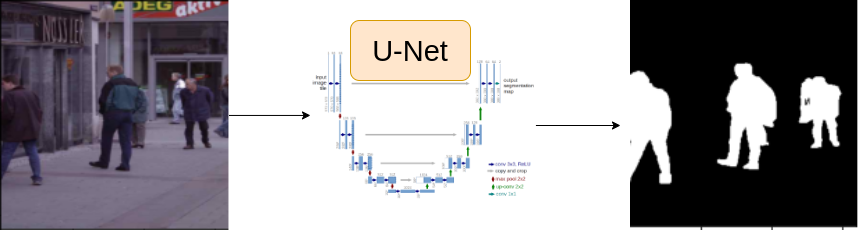

# Some Common Imports

In [31]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [32]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [33]:
csv_file = '/content/Human-Segmentation-Dataset-master/train.csv'
data_dir = '/content/'

DEVICE = 'cuda'

NUM_EPOCHS = 25
LEARNING_RATE = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'



In [34]:
df = pd.read_csv(csv_file)
df.head()


,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [35]:
row = df.iloc[0]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0


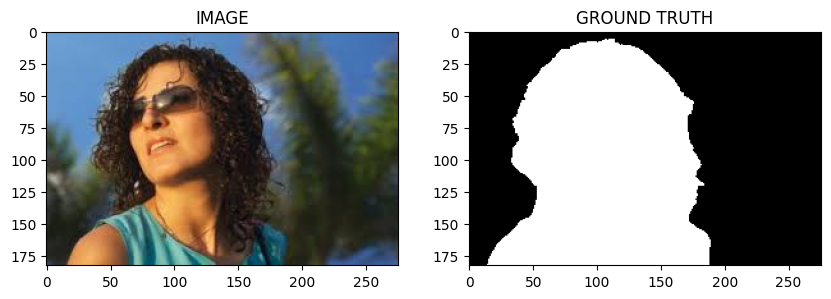

In [36]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [37]:
train_df , valid_df = train_test_split(df , test_size = 0.2 , random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [38]:
import albumentations as A


In [39]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
      A.HorizontalFlip(p=.5),
      A.VerticalFlip(p=.5)
      ],is_check_shapes = False)
def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
  ] , is_check_shapes = False)

# Task 4 : Create Custom Dataset

In [40]:
from torch.utils.data import Dataset

In [41]:
class SegmentationDataset(Dataset) :
  def __init__(self,df,augmentations):
    self.augmentations = augmentations
    self.df = df

  def __len__(self)  :
    return len(self.df)

  def __getitem__ (self , idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path  = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)

    mask  = cv2.imread(mask_path , cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask , axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image , mask = mask)
      image = data['image']
      mask = data['mask']

    #(h,w,c,)->(c,h,w)

    image = np.transpose(image , (2,0,1)).astype(np.float32)
    mask = np.transpose(mask , (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.Tensor(mask) / 255.0

    return image, mask


In [42]:
trainset = SegmentationDataset(train_df , get_train_augs())
validset = SegmentationDataset(valid_df , get_valid_augs())

In [43]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


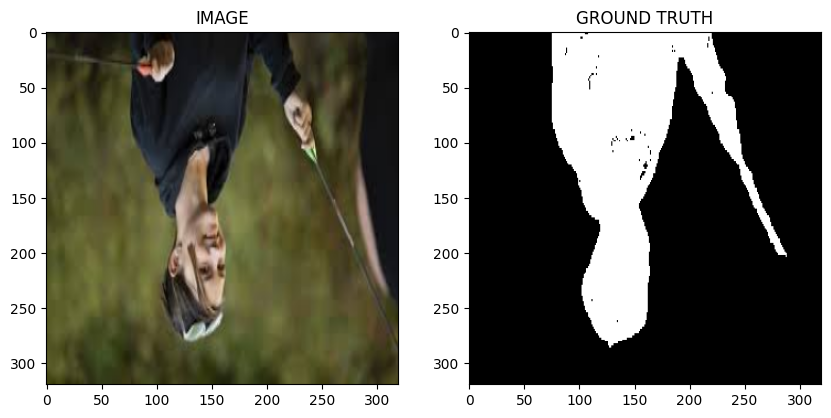

In [44]:
idx = 39
image , mask = trainset[idx]
helper.show_image(image , mask)

# Task 5 : Load dataset into batches

In [45]:
from torch.utils.data import DataLoader

In [46]:
trainloader = DataLoader(trainset , batch_size = BATCH_SIZE , shuffle = True)
validloader = DataLoader(validset , batch_size = BATCH_SIZE)

In [47]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [48]:
for image , mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [49]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [50]:
class SegmentationModel (nn.Module):
  def __init__ (self):
    super(SegmentationModel , self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self ,images ,masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits , masks)
      loss2 = nn.BCEWithLogitsLoss()(logits , masks)
      return logits , loss1 + loss2

    return logits

In [51]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [52]:
def train_fn(data_loader , model , optimizer):

  model.train()
  total_loss = 0.0

  for images , masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

#Resets the gradients of all model parameters.
#This is necessary because gradients accumulate by default in PyTorch.
    optimizer.zero_grad()
    logits ,loss = model(images , masks)
    loss.backward() #backpropagation
    optimizer.step()

    total_loss += loss.item()

  return total_loss/ len(data_loader)


In [53]:
def eval_fn(data_loader , model ):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images , masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits ,loss = model(images , masks)

      total_loss += loss.item()

    return total_loss/ len(data_loader)


# Task 8 : Train Model

In [54]:
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [55]:
best_valid_loss = np.inf

for i in range(NUM_EPOCHS):

  train_loss = train_fn(trainloader , model , optimizer)
  valid_loss = eval_fn(validloader , model)

  if valid_loss < best_valid_loss :
    torch.save(model.state_dict() , 'best_model.pt')
    print("MODEL SAVED")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train_loss : {train_loss}  Valid_loss : {valid_loss}")


100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


MODEL SAVED
Epoch : 1 Train_loss : 0.7115200936794281  Valid_loss : 3.659859001636505


100%|██████████| 4/4 [00:01<00:00,  3.14it/s]


MODEL SAVED
Epoch : 2 Train_loss : 0.4067978660265605  Valid_loss : 0.35567352175712585


100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


MODEL SAVED
Epoch : 3 Train_loss : 0.2918720364570618  Valid_loss : 0.25630639120936394


100%|██████████| 4/4 [00:00<00:00,  5.82it/s]


Epoch : 4 Train_loss : 0.22076112429300945  Valid_loss : 0.2741297483444214


100%|██████████| 4/4 [00:00<00:00,  5.84it/s]


MODEL SAVED
Epoch : 5 Train_loss : 0.22585017780462902  Valid_loss : 0.23500382900238037


100%|██████████| 4/4 [00:00<00:00,  5.86it/s]


Epoch : 6 Train_loss : 0.21153325736522674  Valid_loss : 0.27172620221972466


100%|██████████| 4/4 [00:00<00:00,  5.84it/s]


MODEL SAVED
Epoch : 7 Train_loss : 0.23924352129300436  Valid_loss : 0.2083069048821926


100%|██████████| 4/4 [00:00<00:00,  5.91it/s]


MODEL SAVED
Epoch : 8 Train_loss : 0.17498420675595602  Valid_loss : 0.20620643347501755


100%|██████████| 4/4 [00:00<00:00,  5.81it/s]


Epoch : 9 Train_loss : 0.16096152166525524  Valid_loss : 0.29511434584856033


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


MODEL SAVED
Epoch : 10 Train_loss : 0.17057231962680816  Valid_loss : 0.20095134526491165


100%|██████████| 4/4 [00:00<00:00,  5.96it/s]


Epoch : 11 Train_loss : 0.19014034966627757  Valid_loss : 0.221840962767601


100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


Epoch : 12 Train_loss : 0.19382139394680659  Valid_loss : 0.21508624404668808


100%|██████████| 4/4 [00:00<00:00,  5.87it/s]


Epoch : 13 Train_loss : 0.17177449862162272  Valid_loss : 0.3353167697787285


100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


Epoch : 14 Train_loss : 0.1718549246589343  Valid_loss : 0.20286677405238152


100%|██████████| 4/4 [00:00<00:00,  5.78it/s]


MODEL SAVED
Epoch : 15 Train_loss : 0.13339241097370783  Valid_loss : 0.19939694553613663


100%|██████████| 4/4 [00:00<00:00,  5.65it/s]


MODEL SAVED
Epoch : 16 Train_loss : 0.14236960858106612  Valid_loss : 0.16302911564707756


100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


Epoch : 17 Train_loss : 0.15150788674751917  Valid_loss : 0.18759198114275932


100%|██████████| 4/4 [00:00<00:00,  5.86it/s]


Epoch : 18 Train_loss : 0.12128239323695501  Valid_loss : 0.24168718606233597


100%|██████████| 4/4 [00:00<00:00,  5.66it/s]


Epoch : 19 Train_loss : 0.13065696905056637  Valid_loss : 0.19901560060679913


100%|██████████| 4/4 [00:00<00:00,  5.84it/s]


MODEL SAVED
Epoch : 20 Train_loss : 0.11302881141503653  Valid_loss : 0.15203602239489555


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Epoch : 21 Train_loss : 0.11181111633777618  Valid_loss : 0.2461521103978157


100%|██████████| 4/4 [00:00<00:00,  5.82it/s]


Epoch : 22 Train_loss : 0.11676541169484457  Valid_loss : 0.22458858788013458


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


Epoch : 23 Train_loss : 0.14080402652422588  Valid_loss : 0.21865211427211761


100%|██████████| 4/4 [00:00<00:00,  5.78it/s]


Epoch : 24 Train_loss : 0.14946239044268925  Valid_loss : 0.21849389746785164


100%|██████████| 4/4 [00:00<00:00,  5.77it/s]

Epoch : 25 Train_loss : 0.11974419405062993  Valid_loss : 0.20957940071821213


# Task 9 : Inference

In [56]:
idx = 20
model.load_state_dict(torch.load('/content/best_model.pt'))
image , mask = validset[idx]

logits_mask  = model(image.to(DEVICE).unsqueeze(0)) #(C,H,W) -> (1,C,H,W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > .5)*1.0

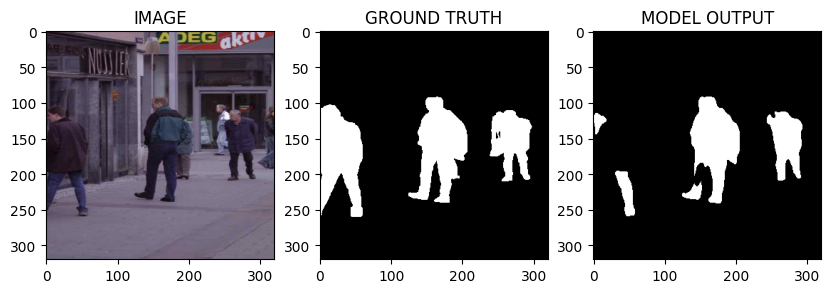

In [57]:
helper.show_image(image , mask , pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya